# **Imports**

In [1]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import warnings


from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import MinMaxScaler, normalize, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from sklearn.neural_network import MLPClassifier, MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.regularizers import L1, L2
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [3]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

# **Data** **Preparation**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_train = pd.read_csv('/content/drive/My Drive/df_train_processed.csv')
df_test = pd.read_csv('/content/drive/My Drive/df_test_processed.csv')

In [6]:
print(df_train.shape, df_test.shape)

(1828, 383) (624, 383)


In [7]:
#standardization
df_train_num = df_train.select_dtypes(include="number").drop("actor", axis=1)
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [8]:
df_test_num = df_test.select_dtypes(include="number").drop("actor", axis=1)
df_test_cat = df_test.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_test_num_scaled = pd.DataFrame(scaler.fit_transform(df_test_num), columns=df_test_num.columns)
df_test = pd.concat([df_test_num_scaled, df_test_cat], axis=1)

In [9]:
print(df_train.shape, df_test.shape)

(1828, 382) (624, 382)


# **Keras**

In [10]:
# function to create accuracy and loss plots
def plot_score_loss(train_scores, val_scores, train_loss, val_loss):
  plt.plot(train_scores, label='TR')
  plt.plot(val_scores, label='VL', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  plt.plot(train_loss, label='TR')
  plt.plot(val_loss, label='VL', linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend(loc='upper right')
  plt.show()

In [11]:
# function to transform continuous output from sigmoid into binary output

def get_pred(predictions):
  y_pred = np.zeros(len(predictions))
  
  for i in range(len(predictions)):  
    if predictions[i] > .5:
      y_pred[i] = 1
    else:
      y_pred[i] = 0

  return y_pred

###**Sex**

#### Data Preparation

In [12]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "M":
      new_array[i] = 1
  return new_array

In [13]:
X_train = df_train.drop("sex", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
#label_encoder = LabelEncoder()
y_train = label_encoder(df_train["sex"])

In [14]:
X_test = df_test.drop("sex", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
#label_encoder = LabelEncoder()
y_test = label_encoder(df_test["sex"])

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 392) (1828,)
(624, 392) (624,)


In [16]:
np.unique(y_train)

array([0., 1.])

In [17]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=42)

In [18]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 392) (1462,)
(366, 392) (366,)


####Baseline

In [104]:
param_grid = {"penalty":["l2", None],
              "C":[1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e2, 1e3], 
              "class_weight": ["balanced"],
              "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
              "max_iter":[200]}
search = GridSearchCV(LogisticRegression(),
                      param_grid,
                      cv=StratifiedKFold(5, shuffle=True, random_state=42),
                      verbose=1,
                      n_jobs=-1,
                      scoring="accuracy"
                      )
search.fit(X_train, y_train)
print(search.best_score_, search.best_estimator_)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_cl

0.9890605584250316 LogisticRegression(C=0.0001, class_weight='balanced', max_iter=200,
                   penalty=None, solver='newton-cg')


In [105]:
model = LogisticRegression(C=0.0001, class_weight="balanced", max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89       312
         1.0       0.85      0.96      0.90       312

    accuracy                           0.90       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.90      0.90       624



#### Prova modello

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
model = Sequential()
model.add(Dense(100, activation="sigmoid", input_dim = X_train.shape[1]))
model.add(Dense(1, activation="sigmoid", kernel_initializer="random_normal"))
model.compile(optimizer = SGD(learning_rate = 0.05, momentum = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               39300     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 39,401
Trainable params: 39,401
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train2, y_train2, epochs=50, batch_size=30, validation_data=(X_val, y_val))

Epoch 1/50
49/49 [==============================] - 2s 11ms/step - loss: 0.6911 - accuracy: 0.5397 - val_loss: 0.6925 - val_accuracy: 0.5109
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.6785 - accuracy: 0.5739 - val_loss: 0.6621 - val_accuracy: 0.6257
Epoch 3/50
49/49 [==============================] - 0s 5ms/step - loss: 0.6531 - accuracy: 0.7059 - val_loss: 0.6474 - val_accuracy: 0.5055
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.7832 - val_loss: 0.6031 - val_accuracy: 0.8934
Epoch 5/50
49/49 [==============================] - 0s 5ms/step - loss: 0.5883 - accuracy: 0.8338 - val_loss: 0.5624 - val_accuracy: 0.8087
Epoch 6/50
49/49 [==============================] - 0s 5ms/step - loss: 0.5413 - accuracy: 0.8488 - val_loss: 0.5076 - val_accuracy: 0.9126
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 0.4896 - accuracy: 0.8728 - val_loss: 0.4577 - val_accuracy: 0.8907
Epoch 8/50
49/49 [=

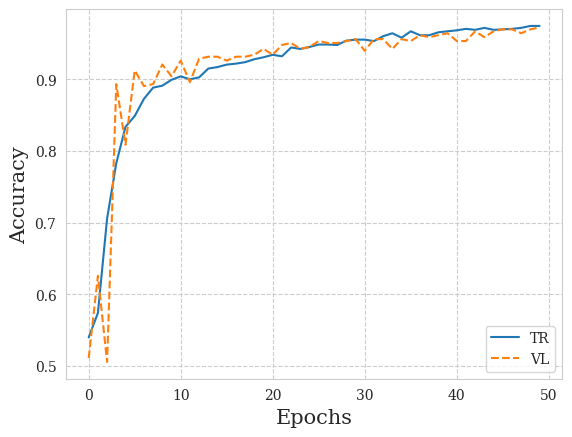

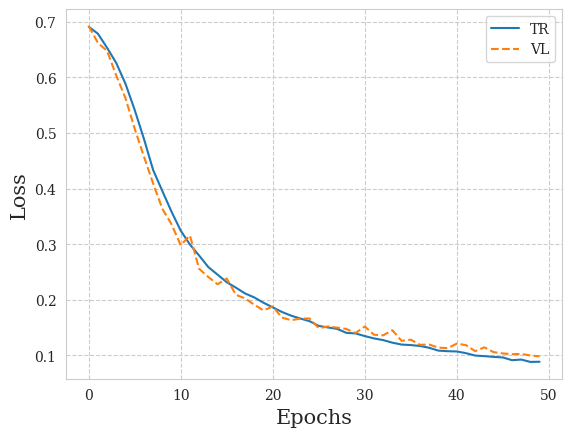

In [21]:
plot_score_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [22]:
y_pred = get_pred(model.predict(X_val))
print(classification_report(y_pred, y_val))

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       181
         1.0       0.97      0.98      0.97       185

    accuracy                           0.97       366
   macro avg       0.97      0.97      0.97       366
weighted avg       0.97      0.97      0.97       366



In [23]:
y_pred = get_pred(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86       312
         1.0       0.80      1.00      0.89       312

    accuracy                           0.87       624
   macro avg       0.90      0.87      0.87       624
weighted avg       0.90      0.87      0.87       624



#### RandomizedSearch

In [60]:
# function to be passed to scikeras wrapper

def build_fn(n_hidden_units, hidden_activation, learning_rate, momentum, regularizer, lambd, initializer, output_activation): 
    keras.backend.clear_session()
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(n_hidden_units, 
                    activation = hidden_activation, 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  regularizer(lambd),
                    kernel_initializer = initializer))
    
    model.add(Dense(1, activation = output_activation, kernel_initializer = initializer))

    model.compile(optimizer = SGD(learning_rate = learning_rate, momentum = momentum),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [83]:
model = KerasClassifier(build_fn,
                n_hidden_units = 264,
                hidden_activation = "sigmoid",
                learning_rate=1,
                momentum=0,
                regularizer=L2,
                lambd=0.1,
                initializer="glorot_normal",
                output_activation="sigmoid",
                #loss="binary_crossentropy",
                random_state=42,
                batch_size=30,
                epochs=50,
                verbose=0
                )

param_grid = {'n_hidden_units': [50, 100, 200],
              'learning_rate': [.01, .1, 1],
              'momentum': [0, .01, .1],
              'lambd': [0, .01, .1],
              'batch_size': [30, 100]
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv = StratifiedKFold(5, shuffle=True, random_state=42), 
                            n_iter=50,
                            verbose = 2,
                            n_jobs = -1,
                            scoring = 'neg_log_loss')

search.fit(X_train, y_train, verbose=2)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Epoch 1/50
49/49 - 0s - loss: 0.6772 - accuracy: 0.6436 - 495ms/epoch - 10ms/step
Epoch 2/50
49/49 - 0s - loss: 0.5905 - accuracy: 0.7168 - 73ms/epoch - 1ms/step
Epoch 3/50
49/49 - 0s - loss: 0.4947 - accuracy: 0.7709 - 77ms/epoch - 2ms/step
Epoch 4/50
49/49 - 0s - loss: 0.2967 - accuracy: 0.8776 - 86ms/epoch - 2ms/step
Epoch 5/50
49/49 - 0s - loss: 0.2526 - accuracy: 0.8940 - 86ms/epoch - 2ms/step
Epoch 6/50
49/49 - 0s - loss: 0.3301 - accuracy: 0.8666 - 76ms/epoch - 2ms/step
Epoch 7/50
49/49 - 0s - loss: 0.3135 - accuracy: 0.8673 - 72ms/epoch - 1ms/step
Epoch 8/50
49/49 - 0s - loss: 0.1870 - accuracy: 0.9295 - 75ms/epoch - 2ms/step
Epoch 9/50
49/49 - 0s - loss: 0.2184 - accuracy: 0.9118 - 81ms/epoch - 2ms/step
Epoch 10/50
49/49 - 0s - loss: 0.2356 - accuracy: 0.9131 - 75ms/epoch - 2ms/step
Epoch 11/50
49/49 - 0s - loss: 0.1768 - accuracy: 0.9391 - 71ms/epoch - 1ms/step
Epoch 12/50
49/49 - 0s - loss: 0.1410 - accuracy: 0.94

In [86]:
keras.backend.clear_session()
tf.random.set_seed(42)
model = Sequential()
model.add(Dense(50, activation="sigmoid", input_dim = X_train.shape[1]))
model.add(Dense(1, activation="sigmoid", kernel_initializer="glorot_normal"))
model.compile(optimizer = SGD(learning_rate = 1, momentum = 0),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                19650     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 19,701
Trainable params: 19,701
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(X_train, y_train, epochs=50, batch_size=30, validation_data=(X_val, y_val))

Epoch 1/50
49/49 [==============================] - 1s 6ms/step - loss: 0.7072 - accuracy: 0.6218 - val_loss: 1.3391 - val_accuracy: 0.5109
Epoch 2/50
49/49 [==============================] - 0s 3ms/step - loss: 0.5428 - accuracy: 0.7469 - val_loss: 0.3101 - val_accuracy: 0.9098
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.8201 - val_loss: 0.4328 - val_accuracy: 0.7978
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 0.3001 - accuracy: 0.8728 - val_loss: 0.2407 - val_accuracy: 0.8907
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2368 - accuracy: 0.9022 - val_loss: 0.1976 - val_accuracy: 0.9262
Epoch 6/50
49/49 [==============================] - 0s 3ms/step - loss: 0.4260 - accuracy: 0.8338 - val_loss: 0.3751 - val_accuracy: 0.8333
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2871 - accuracy: 0.8892 - val_loss: 0.2807 - val_accuracy: 0.8825
Epoch 8/50
49/49 [==

In [88]:
y_pred = get_pred(model.predict(X_val))
print(classification_report(y_pred, y_val))

12/12 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       184
         1.0       0.96      0.98      0.97       182

    accuracy                           0.97       366
   macro avg       0.97      0.97      0.97       366
weighted avg       0.97      0.97      0.97       366



In [91]:
y_pred = get_pred(model.predict(X_test))
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.73      0.84       312
         1.0       0.79      0.99      0.88       312

    accuracy                           0.86       624
   macro avg       0.89      0.86      0.86       624
weighted avg       0.89      0.86      0.86       624



20/20 [==============================] - 0s 2ms/step


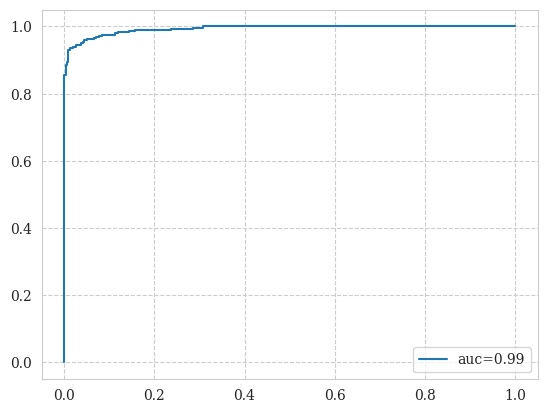

In [107]:
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(round(auc, 2)))
plt.legend(loc=4)
plt.show()

####Constructive Approach

In [36]:
def build_model(n_hidden_units):
    keras.backend.clear_session()
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(n_hidden_units, 
                    activation = "sigmoid", 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  L2(0.01),
                    kernel_initializer = "glorot_normal"))
    
    model.add(Dense(1, 
                    activation = "sigmoid", 
                    kernel_regularizer = L2(0.01),
                    kernel_initializer = "glorot_normal"
                    ))

    model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [37]:
accs = []
units = []
for i in range(200):
    model = build_model(i)
    model.fit(X_train, y_train, epochs=50, batch_size=30, validation_data=(X_val, y_val), verbose=0)
    y_pred = get_pred(model.predict(X_val))
    accs.append(accuracy_score(y_val, y_pred))
    units.append(i)

12/12 [==============================] - 0s 2ms/step


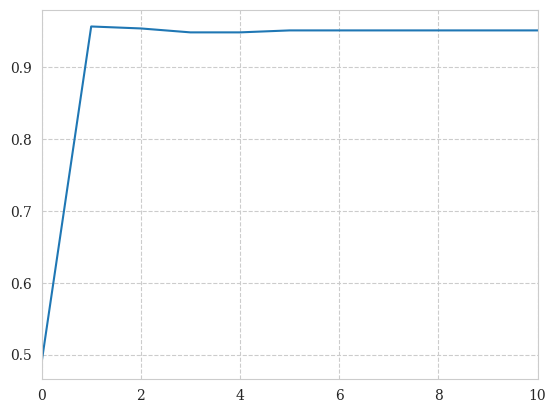

In [45]:
sns.lineplot(x=units, y=accs)
plt.xlim(0,10)
plt.show()

In [75]:
keras.backend.clear_session()
tf.random.set_seed(42)
model = Sequential()
model.add(Dense(1, 
                    activation = "sigmoid", 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  L2(0.01),
                    kernel_initializer = "glorot_normal"))
    
model.add(Dense(1, 
                    activation = "sigmoid", 
                    kernel_regularizer = L2(0.01),
                    kernel_initializer = "glorot_normal"
                    ))

model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])

In [76]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

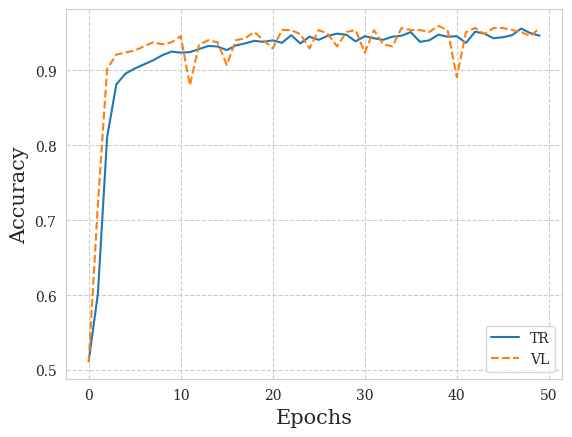

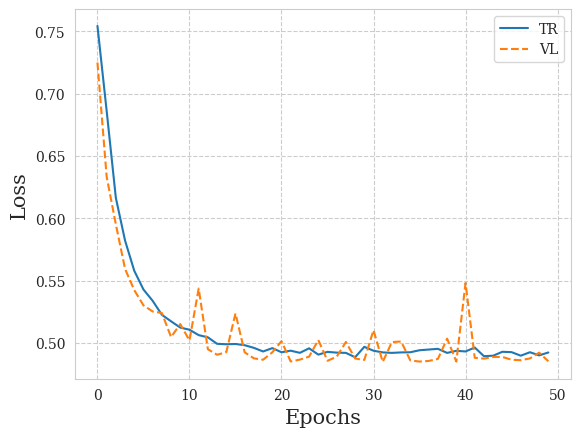

In [77]:
plot_score_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [78]:
y_pred = get_pred(model.predict(X_val))
print(classification_report(y_pred, y_val))

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96       177
         1.0       0.96      0.95      0.96       189

    accuracy                           0.96       366
   macro avg       0.96      0.96      0.96       366
weighted avg       0.96      0.96      0.96       366



In [79]:
y_pred = get_pred(model.predict(X_test))
print(classification_report(y_pred, y_test))

20/20 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       270
         1.0       0.99      0.87      0.93       354

    accuracy                           0.92       624
   macro avg       0.92      0.93      0.92       624
weighted avg       0.93      0.92      0.92       624



In [61]:
model = KerasClassifier(build_fn,
                n_hidden_units = 1,
                hidden_activation = "sigmoid",
                learning_rate=0.1,
                momentum=0,
                regularizer=L2,
                lambd=0.01,
                initializer="glorot_normal",
                output_activation="sigmoid",
                random_state=42,
                batch_size=30,
                epochs=50,
                verbose=0
                )

param_grid = {'learning_rate': [.01, .1, 1],
              'momentum': [0, .001, .01, .1],
              'lambd': [0, .001, .01, .1],
              'batch_size': [32, 64, 128]
              }

search = RandomizedSearchCV(model, 
                            param_grid, 
                            cv = StratifiedKFold(5, shuffle=True, random_state=42), 
                            n_iter=50,
                            verbose = 2,
                            n_jobs = -1,
                            scoring = 'neg_log_loss')

search.fit(X_train, y_train, verbose=2)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Epoch 1/50
46/46 - 1s - loss: 0.6610 - accuracy: 0.6204 - 533ms/epoch - 12ms/step
Epoch 2/50
46/46 - 0s - loss: 0.5808 - accuracy: 0.7250 - 64ms/epoch - 1ms/step
Epoch 3/50
46/46 - 0s - loss: 0.5037 - accuracy: 0.7927 - 76ms/epoch - 2ms/step
Epoch 4/50
46/46 - 0s - loss: 0.3944 - accuracy: 0.8516 - 64ms/epoch - 1ms/step
Epoch 5/50
46/46 - 0s - loss: 0.3491 - accuracy: 0.8707 - 64ms/epoch - 1ms/step
Epoch 6/50
46/46 - 0s - loss: 0.3013 - accuracy: 0.8899 - 62ms/epoch - 1ms/step
Epoch 7/50
46/46 - 0s - loss: 0.3157 - accuracy: 0.8837 - 68ms/epoch - 1ms/step
Epoch 8/50
46/46 - 0s - loss: 0.2366 - accuracy: 0.9241 - 66ms/epoch - 1ms/step
Epoch 9/50
46/46 - 0s - loss: 0.2404 - accuracy: 0.9193 - 65ms/epoch - 1ms/step
Epoch 10/50
46/46 - 0s - loss: 0.2492 - accuracy: 0.9207 - 72ms/epoch - 2ms/step
Epoch 11/50
46/46 - 0s - loss: 0.2480 - accuracy: 0.9159 - 64ms/epoch - 1ms/step
Epoch 12/50
46/46 - 0s - loss: 0.2309 - accuracy: 0.92

In [63]:
keras.backend.clear_session()
tf.random.set_seed(42)
model = Sequential()
model.add(Dense(1, 
                    activation = "sigmoid", 
                    input_shape = (X_train.shape[1],),
                    kernel_regularizer =  L2(0),
                    kernel_initializer = "glorot_normal"))
    
model.add(Dense(1, 
                    activation = "sigmoid", 
                    kernel_regularizer = L2(0),
                    kernel_initializer = "glorot_normal"
                    ))

model.compile(optimizer = SGD(learning_rate = 1, momentum = 0.01),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])

In [64]:
history = model.fit(X_train, y_train, epochs=50, batch_size=30, validation_data=(X_val, y_val), verbose=0)

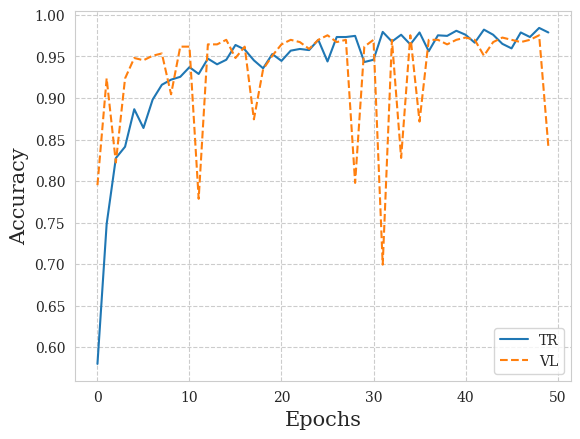

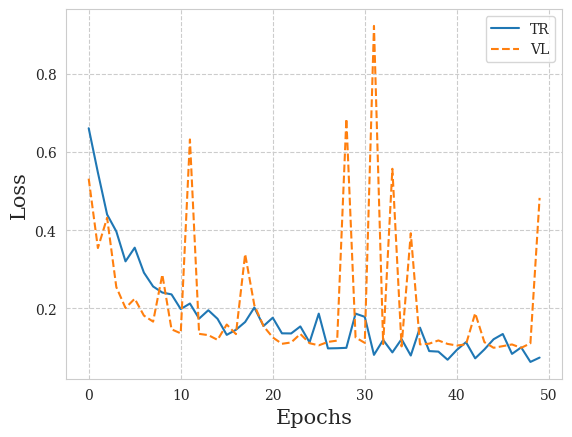

In [65]:
plot_score_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [66]:
y_pred = get_pred(model.predict(X_val))
print(classification_report(y_pred, y_val))

12/12 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81       121
         1.0       1.00      0.76      0.87       245

    accuracy                           0.84       366
   macro avg       0.84      0.88      0.84       366
weighted avg       0.89      0.84      0.85       366



###**Emotion**

#### Data Preparation

In [20]:
def label_encoder(array):
  new_array = np.zeros(len(array))
  for i in range(len(array)):
    if array[i] == "calm":
      new_array[i] = 1
    elif array[i] == "happy":
      new_array[i] = 2
    elif array[i] == "sad":
      new_array[i] = 3
    elif array[i] == "angry":
      new_array[i] = 4
    elif array[i] == "fearful":
      new_array[i] = 5
    elif array[i] == "disgust":
      new_array[i] = 6
    elif array[i] == "surprised":
      new_array[i] = 7
  return new_array

In [21]:
X_train = df_train.drop("emotion", axis=1)
X_train = pd.get_dummies(X_train).to_numpy() #one-hot encoding + conversion into np array
#label_encoder = LabelEncoder()
y_train = label_encoder(df_train["emotion"])

In [22]:
X_test = df_test.drop("emotion", axis=1)
X_test = pd.get_dummies(X_test).to_numpy() #one-hot encoding + conversion into np array
#label_encoder = LabelEncoder()
y_test = label_encoder(df_test["emotion"])

In [23]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1828, 386) (1828,)
(624, 386) (624,)


In [24]:
np.unique(y_train)

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [25]:
# splitting VL
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=42)

In [26]:
print(X_train2.shape, y_train2.shape)
print(X_val.shape, y_val.shape)

(1462, 386) (1462,)
(366, 386) (366,)


In [145]:
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
train_y_labels = label_as_binary.fit_transform(y_train2)

#### Prova modello

In [55]:
keras.backend.clear_session()
tf.random.set_seed(42)
model = Sequential()
model.add(Dense(100, activation="relu", input_dim = X_train.shape[1], kernel_initializer="glorot_normal"))
model.add(Dense(100, activation="relu", kernel_initializer="glorot_normal"))
model.add(Dense(8, activation="softmax", kernel_initializer="glorot_normal"))
model.compile(optimizer = SGD(learning_rate = 0.1, momentum = 0.01),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               38700     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
Total params: 49,608
Trainable params: 49,608
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(X_train2, y_train2, epochs=100, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
46/46 [==============================] - 1s 7ms/step - loss: 1.9981 - accuracy: 0.1943 - val_loss: 1.9362 - val_accuracy: 0.2158
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 1.8522 - accuracy: 0.2510 - val_loss: 1.8128 - val_accuracy: 0.2896
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 1.7988 - accuracy: 0.2668 - val_loss: 1.7181 - val_accuracy: 0.2705
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 1.7638 - accuracy: 0.2873 - val_loss: 1.6907 - val_accuracy: 0.3169
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 1.6568 - accuracy: 0.3406 - val_loss: 1.5778 - val_accuracy: 0.3224
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 1.6489 - accuracy: 0.3420 - val_loss: 1.7541 - val_accuracy: 0.3033
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 1.5940 - accuracy: 0.3694 - val_loss: 2.3557 - val_accuracy: 0.1694
Epoch 8/100
4

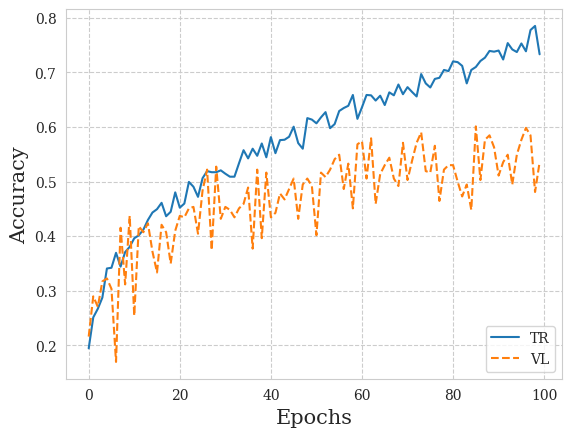

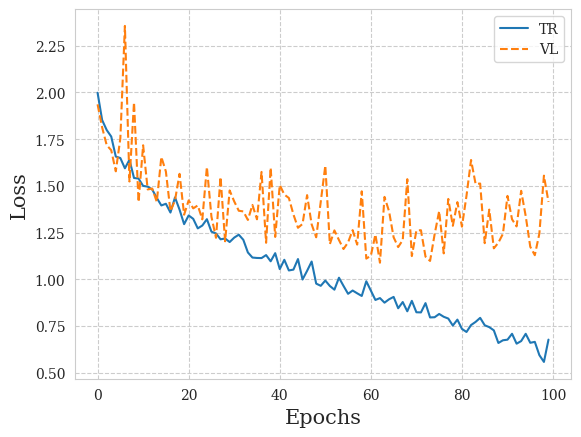

In [57]:
plot_score_loss(history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss'])

In [47]:
def get_pred_softmax(predictions):
  preds = [list(pred).index(max(pred)) for pred in predictions]
  return np.array(preds)

y_pred = get_pred_softmax(model.predict(X_val))

12/12 [==============================] - 0s 6ms/step


In [48]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.21      0.46      0.29        13
           1       0.84      0.50      0.63        94
           2       0.84      0.36      0.51       130
           3       0.05      0.43      0.10         7
           4       0.91      0.76      0.83        67
           5       0.16      0.90      0.27        10
           6       0.52      0.60      0.56        25
           7       0.34      0.50      0.41        20

    accuracy                           0.51       366
   macro avg       0.48      0.56      0.45       366
weighted avg       0.75      0.51      0.57       366

